In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from dotenv import load_dotenv
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import Image, display

In [3]:
model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

In [4]:
def display_graph(app):
    # this function will display the graph of the app
    try:
        display(Image(app.get_graph().draw_mermaid_png()))
    except Exception as e:
        # This requires some extra dependencies and is optional
        print(e)

In [5]:
def stream_output(app, input):
    for output in app.stream(input):
        for key,value in output.items():
            print(f"here is output from {key}")
            print("_______")
            print(value)
            print("\n")

## Simple workflow in a graph

In [6]:
def greet_user(name):
    '''
    This function will greet the user with a message
    '''
    return f"Hello {name}!"


def convert_to_uppercase(input_word):
    '''
    This function will convert the input word to uppercase
    '''
    return input_word.upper()

In [10]:
from langgraph.graph import Graph

workflow = Graph()
workflow.add_node("User_greetings" , greet_user)
workflow.add_node("Uppercase_converter" , convert_to_uppercase)
workflow.add_edge("User_greetings" , "Uppercase_converter")
workflow.set_entry_point("User_greetings")
workflow.set_finish_point("Uppercase_converter")
app = workflow.compile()

app.invoke("Suman")


'HELLO SUMAN!'

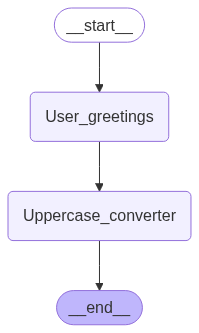

In [11]:
display_graph(app)

In [12]:
stream_output(app, 'Suman')

here is output from User_greetings
_______
Hello Suman!


here is output from Uppercase_converter
_______
HELLO SUMAN!




## Workflow using a llm and a function

In [13]:
def response_from_llm(input_text):
    '''
    this function return a response from an llm
    '''
    response = model.invoke(input_text)
    return response.content


def convert_to_uppercase(input_text):
    '''
    this function will convert the input text to uppercase
    '''
    return input_text.upper()


In [14]:
workflow = Graph()
workflow.add_node("Get_ans_from_llm" , response_from_llm)
workflow.add_node("Convert_to_uppercase" , convert_to_uppercase)
workflow.add_edge("Get_ans_from_llm" , "Convert_to_uppercase")
workflow.set_entry_point("Get_ans_from_llm")
workflow.set_finish_point("Convert_to_uppercase")
app = workflow.compile()

app.invoke("What is the capital of France?")

'THE CAPITAL OF FRANCE IS PARIS.'

In [15]:
app.invoke("Who was the first president of the United States?")

'THE FIRST PRESIDENT OF THE UNITED STATES WAS GEORGE WASHINGTON.'

# Integrating RAG in workflow

In [16]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [20]:
loader=DirectoryLoader("../data",glob="./*.txt",loader_cls=TextLoader)
docs=loader.load()
print(docs)
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function = len
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

[Document(metadata={'source': '../data/bangaldesh_manufacturing-industry.txt'}, page_content="# The Rise of Bangladesh's Manufacturing Industry\n\nBangladesh's manufacturing sector has undergone a remarkable transformation over the past few decades, emerging as a key driver of the nation's economic growth. Once primarily dependent on agriculture, Bangladesh has successfully diversified its economy, with manufacturing now contributing approximately 20% to its GDP.\n\nThe ready-made garment (RMG) industry stands as the cornerstone of Bangladesh's manufacturing success. Since the 1980s, Bangladesh has become the world's second-largest apparel exporter after China, employing over 4 million workers, predominantly women. This sector accounts for more than 80% of the country's export earnings, demonstrating its crucial economic significance.\n\nSeveral factors have fueled this industrial expansion. Low labor costs provided Bangladesh with a competitive advantage in labor-intensive manufacturi

In [19]:
doc_strings

["# The Rise of Bangladesh's Manufacturing Industry\n\nBangladesh's manufacturing sector has undergone a remarkable transformation over the past few decades, emerging as a key driver of the nation's economic growth. Once primarily dependent on agriculture, Bangladesh has successfully diversified its economy, with manufacturing now contributing approximately 20% to its GDP.\n\nThe ready-made garment (RMG) industry stands as the cornerstone of Bangladesh's manufacturing success. Since the 1980s, Bangladesh has become the world's second-largest apparel exporter after China, employing over 4 million workers, predominantly women. This sector accounts for more than 80% of the country's export earnings, demonstrating its crucial economic significance.",
 'Several factors have fueled this industrial expansion. Low labor costs provided Bangladesh with a competitive advantage in labor-intensive manufacturing. Strategic government policies, including export processing zones, tax incentives, and p

In [21]:
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()
db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 3})

In [22]:
retriever.get_relevant_documents("tell me about bangaldesh industrial growth")

/var/folders/wt/k9xk77m14_scry8y3ldyfjr00000gn/T/ipykernel_60010/1315298168.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retriever.get_relevant_documents("tell me about bangaldesh industrial growth")


[Document(metadata={'source': '../data/bangaldesh_manufacturing-industry.txt'}, page_content="Despite impressive growth, challenges persist. Infrastructure limitations, particularly unreliable electricity supply and inadequate transportation networks, continue to hamper productivity. Environmental concerns have intensified as industrial expansion often outpaces regulatory oversight. Labor rights and workplace safety remain significant issues, especially following the 2013 Rana Plaza tragedy which prompted industry-wide reforms.\n\nLooking ahead, Bangladesh's manufacturing sector is positioning itself for sustainable growth through technological adoption, workforce development, and environmental compliance. The government's Vision 2041 plan emphasizes industrial modernization and diversification, aiming to elevate Bangladesh to developed nation status. With continued investment in innovation, skills development, and infrastructure, Bangladesh's manufacturing industry appears poised for 

In [27]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough , RunnableParallel
from langchain.chains import RetrievalQA

In [28]:
AgentState ={}
AgentState["messages"] = []


def extract_topics(state):
    messages = state['messages']  ##asssuming state is a dict with messages key
    question = messages[-1]   ## Fetching the user question
    complete_query = "Your task is to extract topic from the following query . If the extracted topic is two words or more, the topic should be in the form of 'word1_word2' . If the extracted topic is one word, the topic should be in the form of 'word1' . Following is the user query: " + question
    response = model.invoke(complete_query)
    state['messages'].append(response.content)
    return state

def call_rag(state):
    messages = state['messages']
    question = messages[0] ## Fetching the user question

    template = """Answer the question based only on the following context:
    {context}
    Donot answer anything out of the context, if you dont find the answer in the context, then say "I don't know"
    Question: {question}
    """
    
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        RunnableParallel({"context": retriever, "question": RunnablePassthrough()})
        | prompt
        | model
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return result


In [30]:
workflow = Graph()

workflow.add_node("Extract_topics", extract_topics)
workflow.add_node("RAG_call", call_rag)

workflow.add_edge('Extract_topics', 'RAG_call')

workflow.set_entry_point("Extract_topics")
workflow.set_finish_point("RAG_call")

app = workflow.compile()

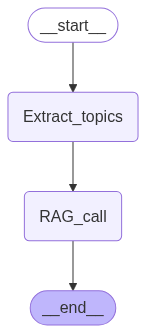

In [31]:
display_graph(app)

In [32]:
print(app.invoke({"messages": ["tell me about bangaldesh industrial growth"]}))

Bangladesh's manufacturing sector has experienced remarkable growth over the past few decades, transforming from an agriculture-dependent economy to one where manufacturing contributes about 20% to GDP. The ready-made garment (RMG) industry is central to this success, making Bangladesh the world's second-largest apparel exporter after China and employing over 4 million workers, mostly women. This sector accounts for more than 80% of the country's export earnings.

Several factors have fueled this industrial expansion, including low labor costs, strategic government policies such as export processing zones, tax incentives, and preferential trade agreements that have attracted significant foreign direct investment. Improved infrastructure in power generation and transportation has also enhanced production capabilities.

Beyond garments, Bangladesh has diversified into pharmaceuticals, shipbuilding, electronics, and leather goods. The pharmaceutical industry now meets 98% of domestic dema

In [33]:
stream_output(app, {"messages": ["tell me about bangaldesh industrial growth"]})

here is output from Extract_topics
_______
{'messages': ['tell me about bangaldesh industrial growth', 'bangladesh_industrial_growth']}


here is output from RAG_call
_______
Bangladesh's manufacturing sector has experienced remarkable growth over the past few decades, transforming from an agriculture-dependent economy to one where manufacturing contributes about 20% to GDP. The ready-made garment (RMG) industry is central to this success, making Bangladesh the world's second-largest apparel exporter after China and employing over 4 million workers, mostly women. This sector accounts for more than 80% of the country's export earnings.

Several factors have fueled this industrial expansion, including low labor costs, strategic government policies such as export processing zones, tax incentives, and preferential trade agreements that attract foreign direct investment. Improved infrastructure in power generation and transportation has also enhanced production capabilities. Beyond garments

### Pydantic use case

In [ ]:
import os 
from dotenv import load_dotenv
load_dotenv()

from langgraph.graph import StateGraph , START , END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage , AIMessage , SystemMessage
from typing import TypedDict , Annotated
from pydantic import BaseModel , Field

#define the state
class GraphState(TypedDict):
    messages : Annotated[list, add_messages]
    quality_score : Annotated[int, None]
    num_words : Annotated[int, None]

model = ChatOpenAI(model="gpt-4.1-mini", temperature=0 , max_completion_tokens=500)

class GenerateCode(BaseModel):
    """ 
    Extract the generated code and the num of words in the code
    """
    code : str = Field(description="Generated software code")
    num_words : int = Field(description="Number of words in the generated code")

class EvaluateCode(BaseModel):
    """
    Evaluate the generated code and return the quality score and comments
    """
    comments : str = Field(description="Comments on the quality score")
    quality_score : int = Field(description="Quality score of the generated code between 0 and 100")

developer_structured_llm = model.with_structured_output(GenerateCode)
evaluator_structured_llm = model.with_structured_output(EvaluateCode)


# nodes definition

#set the initial state
def init(state):
    print("----------- Init node ------------")
    print("State: ", state)
    return {
        "messages": [] , 
        "quality_score": 0 , 
        "num_words": 0
    }

#create a developer node 
def generate_code(state):
    print("----------- Generate code node ------------")
    system_prompt = """You are a software developer. You are given a task to generate a software code.
    You will be given a task and you will need to generate a software code for the task.
    Respond in json format with the following keys:
    code: The generated software code
    num_words: The number of words in the generated code
    """

    human_message  = [msg for msg in state["messages"] if isinstance(msg, HumanMessage)]
    ai_message = [msg for msg in state["messages"] if isinstance(msg, AIMessage)]
    system_message = [SystemMessage(content=system_prompt)]
    messages = system_message + ai_message + human_message

    developer_output = developer_structured_llm.invoke(messages)

    print("Code generated by developer: ", developer_output.code)

    print("--------------- developer output ---------------")

    return {
        "messages": [developer_output.code] , 
        "num_words": developer_output.num_words
    }


def evaluate_code(state):
    print("----------- Evaluate code node ------------")
    system_prompt = """
    You are a high standard code reviewer. You will be given a code and you will need to evaluate the code and return the quality score and comments.
    The quality score should be between 0 and 100.
    Assess the structure , code quality and documentation of the code.
    Respond in json format with the following keys:
    comments: Comments on the quality score
    quality_score: Quality score of the generated code between 0 and 100
    """

    human_message  = [msg for msg in state["messages"] if isinstance(msg, HumanMessage)]
    ai_message = [msg for msg in state["messages"] if isinstance(msg, AIMessage)]
    system_message = [SystemMessage(content=system_prompt)]
    messages = system_message + ai_message + human_message

    evaluator_output = evaluator_structured_llm.invoke(messages)

    print("Code evaluated by evaluator: ", evaluator_output.comments)
    print("--------------- evaluator output ---------------")

    return {
        "comments": [evaluator_output.comments] , 
        "quality_score": evaluator_output.quality_score
    }

def summary(state):
    print("----------- Summary node ------------")
    print("Summary: ", state)
    return state


workflow = StateGraph(GraphState)
workflow.add_node("init" , init)
workflow.add_node("generate_code" , generate_code)
workflow.add_node("evaluate_code" , evaluate_code)
workflow.add_node("summary" , summary)
workflow.add_edge(START , "init")
workflow.add_edge("init" , "generate_code")
workflow.add_edge("generate_code" , "evaluate_code")
workflow.add_edge("evaluate_code" , "summary")
workflow.add_edge("summary" , END)
app = workflow.compile()


if __name__ == "__main__":

    while True:
        user_input = input("Enter your coding task: ")
        if user_input.lower() == "exit":
            break
        result = app.invoke({"messages": [HumanMessage(content=user_input)]})

## Rag + AgentState + conditional edges

In [29]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph , START , END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage , AIMessage , SystemMessage
from typing import TypedDict , Annotated
from pydantic import BaseModel , Field

In [56]:
class GraphState(TypedDict):
    topic : Annotated[str, None]
    llm_response : Annotated[str, None]
    rag_response : Annotated[str, None]
    messages : Annotated[list, add_messages]



In [58]:
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate

class TopicSelector(BaseModel):
    """
    you have to extract the topic from the user query.
    """
    topic : str = Field(description="The topic of the user query")

topic_extracction_llm = model.with_structured_output(TopicSelector)

class RAGResponse(BaseModel):
    """
    You have to provide response from the RAG agent.
    """
    rag_response : str = Field(description="The response from the RAG agent")

rag_structured_llm = model.with_structured_output(RAGResponse)


class LLMResponse(BaseModel):
    """
    You have to call the LLM agent.
    """
    llm_response : str = Field(description="The response from the LLM agent")

structured_llm = model.with_structured_output(LLMResponse)


topic_parser = PydanticOutputParser(pydantic_object=TopicSelector)
rag_parser = PydanticOutputParser(pydantic_object=RAGResponse)
llm_parser = PydanticOutputParser(pydantic_object=LLMResponse)



In [59]:
def extract_topic(state):
    print('-> Calling topic extraction agent ->')

    topic_extraction_system_prompt = """
    You are a topic extraction agent. You will be given a user query and you will need to extract the topic of the user query.
    the topic may be related to Bangladesh or non Bangladesh related.
    

    Respond in json format with the following keys:
    
    topic: The topic of the user query.if the topic is related to Bangladesh, then output 'Bangladesh' else output 'Not Related'.

    """

    human_message = [msg for msg in state["messages"] if isinstance(msg, HumanMessage)]
    ai_message = [msg for msg in state["messages"] if isinstance(msg, AIMessage)]
    system_message = [SystemMessage(content=topic_extraction_system_prompt)]

    messages = system_message + ai_message + human_message
    
    
    topic_response = topic_extracction_llm.invoke(messages)

    return {
        "messages": [topic_response.topic],
        "topic": topic_response.topic
    }


def call_rag(state):
    messages = state['messages']
    question = messages[0] ## Fetching the user question

    template = """Answer the question based only on the following context:
    {context}
    Donot answer anything out of the context, if you dont find the answer in the context, then say "I don't know"
    Question: {question}
    """
    
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        RunnableParallel({"context": retriever, "question": RunnablePassthrough()})
        | prompt
        | model
        | rag_structured_llm
        )
    result = retrieval_chain.invoke(question)
    return {
        "messages": [result.rag_response],
        "rag_response": result.rag_response
    }
    

def call_llm(state):
    print('-> Calling LLM agent ->')
    messages = state['messages']
    question = messages[0]

    calling_llm_system_prompt = """
    You are a helpful assistant that can answer questions about the user query.
    follwoing is the user question 
    {question}
    """

    human_message = [msg for msg in state["messages"] if isinstance(msg, HumanMessage)]
    ai_message = [msg for msg in state["messages"] if isinstance(msg, AIMessage)]
    system_message = [SystemMessage(content=calling_llm_system_prompt)]
    messages = system_message + ai_message + human_message

    llm_structured_response = structured_llm.invoke(messages)

    return {
        "messages": [llm_structured_response.llm_response],
        "llm_response": llm_structured_response.llm_response
    }
    
def router(state):
    print('-> Calling Router agent ->')
    messages = state['messages']
    last_message = messages[-1]
    if 'Bangladesh' in last_message or 'bangaldesh' in last_message:
        return 'RAG_call'
    else:
        return 'LLM_call'


In [61]:
from langgraph.graph import StateGraph , START , END

workflow = StateGraph(GraphState)
workflow.add_node("topic_extraction" , extract_topic)
workflow.add_node("RAG" , call_rag)
workflow.add_node("LLM" , call_llm)
workflow.add_edge(START , "topic_extraction")
workflow.add_conditional_edges("topic_extraction" ,
                               router,
                               {
                                   "RAG_call" : "RAG",
                                   "LLM_call" : "LLM"
                               }
                               )
workflow.add_edge("RAG" , END)
workflow.add_edge("LLM" , END)
app = workflow.compile()

if __name__ == "__main__":
    while True:
        user_input = input("Enter your question: ")
        if user_input.lower() == "exit":
            break
        result = app.invoke({"messages": [HumanMessage(content=user_input)]})
        print(result["topic"])

-> Calling topic extraction agent ->
-> Calling Router agent ->
-> Calling LLM agent ->
Bangladesh
-> Calling topic extraction agent ->
-> Calling Router agent ->
-> Calling LLM agent ->
Not Related
-> Calling topic extraction agent ->
-> Calling Router agent ->
-> Calling LLM agent ->
Not Related


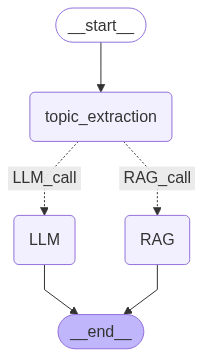

In [62]:
display_graph(app)

In [71]:
app.invoke({"messages": ["tell me about bangaldesh industrial growth"]})

-> Calling topic selection agent ->
-> Calling Router agent ->
Bangaldesh
-> Calling RAG agent ->


{'messages': ['tell me about bangaldesh industrial growth',
  'Bangaldesh',
  "Bangladesh's manufacturing sector has experienced significant growth over the past few decades, transforming from an economy primarily reliant on agriculture to one where manufacturing contributes approximately 20% to its GDP. The ready-made garment (RMG) industry is a key component of this success, making Bangladesh the world's second-largest apparel exporter after China and employing over 4 million workers, mostly women. This sector accounts for more than 80% of the country's export earnings.\n\nSeveral factors have fueled this industrial expansion, including low labor costs, strategic government policies such as export processing zones and tax incentives, and improved infrastructure in power generation and transportation. Additionally, Bangladesh has diversified its manufacturing beyond garments into sectors like pharmaceuticals, shipbuilding, electronics, and leather goods.\n\nDespite this impressive gro

In [75]:
app.invoke({"messages": ["tell me about prime minsiter of India"]})

-> Calling topic selection agent ->
-> Calling Router agent ->
Not Related
-> Calling LLM agent ->


{'messages': ['tell me about prime minsiter of India',
  'Not Related',
  "As of my last knowledge update in October 2023, the Prime Minister of India is Narendra Modi. He has been in office since May 26, 2014, after his party, the Bharatiya Janata Party (BJP), won a decisive victory in the general elections. Modi was re-elected for a second term following the 2019 general elections, where the BJP again secured a significant majority.\n\nNarendra Modi was born on September 17, 1950, in Vadnagar, Gujarat. Before becoming Prime Minister, he served as the Chief Minister of Gujarat from 2001 to 2014. His tenure as Prime Minister has been marked by several key initiatives, including:\n\n1. **Economic Reforms**: Modi's government has implemented various economic reforms aimed at boosting growth, including the Goods and Services Tax (GST) and the Make in India initiative to promote manufacturing.\n\n2. **Digital India**: This initiative aims to transform India into a digitally empowered socie

In [73]:
AgentState["messages"]   

__main__.AgentState['messages']